
Class distribution in training set:
Counter({'not completed': 210001, 'completed': 192316})

Class distribution in test set:
Counter({'not completed': 52501, 'completed': 48079})
Selected 100 samples for SHAP analysis.
SHAP values type: <class 'numpy.ndarray'>


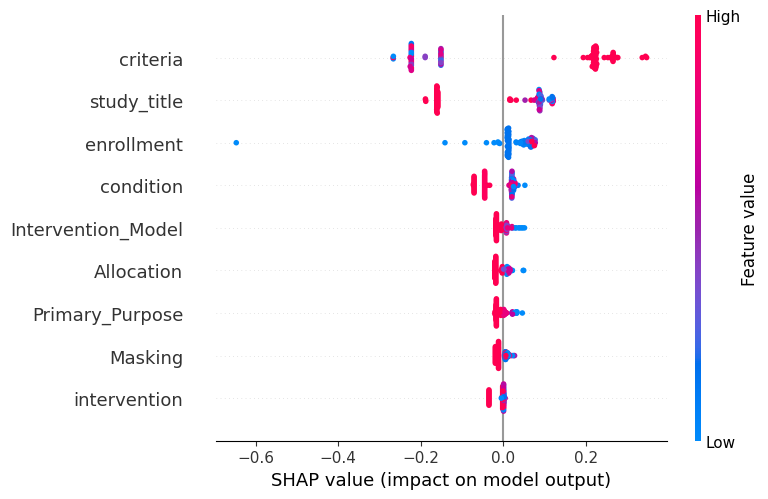

SHAP values aligned with features.
SHAP summary plot saved.
Top 9 features by mean absolute SHAP value:
1. criteria
2. study_title
3. enrollment
4. condition
5. Intervention_Model
6. Allocation
7. Primary_Purpose
8. Masking
9. intervention
Generating dependence plot for criteria
Generating dependence plot for study_title
Generating dependence plot for enrollment
Generating dependence plot for condition
Generating dependence plot for Intervention_Model
Generating dependence plot for Allocation
Generating dependence plot for Primary_Purpose
Generating dependence plot for Masking
Generating dependence plot for intervention


In [2]:
import shap
import joblib
import pandas as pd
from collections import Counter
import sys
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
import time

warnings.filterwarnings('ignore')

# Add path to find data_processing if needed (customize as necessary)
sys.path.append(os.path.abspath('./src'))

# Load trained model
model_path = 'models/random_forest_model.pkl'
model = joblib.load(model_path)

# Load label encoders and scaler
label_encoders_path = 'data/processed/label_encoders.pkl'
label_encoders = joblib.load(label_encoders_path)

def load_processed_data(processed_dir='data/processed'):
    """
    Load preprocessed data from CSV files.
    """
    X_train = pd.read_csv(os.path.join(processed_dir, 'X_train.csv'))
    X_test = pd.read_csv(os.path.join(processed_dir, 'X_test.csv'))
    y_train = pd.read_csv(os.path.join(processed_dir, 'y_train.csv'))
    y_test = pd.read_csv(os.path.join(processed_dir, 'y_test.csv'))
    
    # Make sure 'study_status' is present
    if 'study_status' not in y_test.columns:
        print("Warning: 'study_status' not found in y_test. Adding placeholder values.")
        y_test['study_status'] = None
    
    # Print class distribution
    print("\nClass distribution in training set:")
    print(Counter(y_train['study_status']))
    print("\nClass distribution in test set:")
    print(Counter(y_test['study_status']))
    
    return X_train, X_test, y_train, y_test

# Load data
X_train, X_test, y_train, y_test= load_processed_data()

# Take a sample for SHAP analysis
X_sample = X_train.sample(n=100, random_state=42)

# Remove target column if present
if 'study_status' in X_sample.columns:
    X_sample_features = X_sample.drop(columns=['study_status'])
else:
    X_sample_features = X_sample.copy()

# Select numeric columns
numeric_cols = X_sample_features.select_dtypes(include=['int64', 'float64']).columns
X_sample_numeric = X_sample_features[numeric_cols]
print(f"Selected {X_sample_numeric.shape[0]} samples for SHAP analysis.")

# Initialize SHAP explainer (assuming single-output classification)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample_numeric)
print(f"SHAP values type: {type(shap_values)}")

# Handle single vs. list of SHAP arrays
if isinstance(shap_values, list):
    # For binary classification, shap_values is a list with two arrays
    shap_values_selected = shap_values[0]
else:
    shap_values_selected = shap_values

# After computing shap_values:
# shap_values.shape == (100, 5, 2)

if shap_values.ndim == 3:
    # For a binary classifier, pick class index 0 or 1
    class_index = 0  # or 1
    shap_values_selected = shap_values[:, :, class_index]
else:
    shap_values_selected = shap_values

# Now shap_values_selected.shape == (100, 5)
# Proceed with plotting, e.g.:
shap.summary_plot(shap_values_selected, X_sample_numeric)

# Verify shape alignment
if shap_values_selected.shape != X_sample_numeric.shape:
    raise ValueError(f"Shape mismatch: {shap_values_selected.shape} vs {X_sample_numeric.shape}")
else:
    print("SHAP values aligned with features.")

# Plot summary
shap.summary_plot(shap_values_selected, X_sample_numeric, show=False)
plt.savefig('./notebooks/shap_summary_plot.png', bbox_inches='tight')
plt.close()
print("SHAP summary plot saved.")

# Identify top features by mean absolute SHAP values
feature_importance = (
    pd.DataFrame(shap_values_selected, columns=numeric_cols)
    .abs()
    .mean()
    .sort_values(ascending=False)
)
top_n = min(20, len(feature_importance))  # up to 20 or fewer
top_features = feature_importance.head(top_n).index.tolist()

print(f"Top {top_n} features by mean absolute SHAP value:")
for i, feat in enumerate(top_features, 1):
    print(f"{i}. {feat}")

# Generate dependence plots
output_dir = './notebooks/shap_dependence_plots/'
os.makedirs(output_dir, exist_ok=True)
for feature in top_features:
    print(f"Generating dependence plot for {feature}")
    try:
        shap.dependence_plot(feature, shap_values_selected, X_sample_numeric, interaction_index=None, show=False)
        plt.savefig(os.path.join(output_dir, f'dependence_{feature}.png'), bbox_inches='tight', dpi=100)
        plt.close()
    except Exception as e:
        print(f"Failed to generate plot for {feature}: {e}")

# Create and save SHAP values DataFrame
shap_df = pd.DataFrame(shap_values_selected, columns=numeric_cols)

# If 'study_status' is in y_test, we can associate it
if 'study_status' in y_test.columns:
    shap_df['study_status'] = y_test['study_status'].values[: len(shap_df)]
else:
    shap_df['study_status'] = None
